# Variable Importance analysis

Variable importance (a.k.a. VarImp) is an approach to examine the
importance of software metrics for random forest models. There are two
commonly-used calculation approaches of variable importance scores,
namely, Gini Importance and Permutation Importance, which we describe
below.

**Gini Importance (a.k.a. MeanDecreaseGini)** determines the importance
of metrics from the decrease of the Gini Index, i.e., the distinguishing
power for the defective class due to a given
metric {cite}`breiman2001random`. We start from a random
forest model that is constructed using the original dataset with
multiple trees, where each tree is constructed using a bootstrap sample.
For each tree, a parent node (i.e., $G_{\mathrm{Parent}}$) is split by
the best cut-point into two descendent nodes (i.e.,
$G_{\mathrm{Desc.1}}$ and $G_{\mathrm{Desc.2}}$). The calculation of the
Gini Importance of each metric is made up of 2 steps:

*(Step 1) Compute the DecreaseGini for all of the trees in the random
forest model.* The DecreaseGini is the improvement of the ability to
distinguish between two classes across parent and its descendent nodes.
We compute the DecreaseGini using the following equation:

$$\mathrm{DecreaseGini}(m_i) = I_{m_i} = G_{\mathrm{Parent}} - G_{\mathrm{Desc.1}} - G_{\mathrm{Desc.2}}$$

where $G$ is the Gini Index, i.e., the distinguishing power of defective
class for a given metric. The Gini Index is computed using the following
equation: $G = \sum_{i=1}^{N_{\mathrm{Class}}}p_i(1-p_i)$, where
$N_{\mathrm{Class}}$ is the number of classes and $p_i$ is the
proportion of Class$_i$.

*(Step 2) Compute the MeanDecreaseGini measure.* Finally, the importance
of each metric (i.e., MeanDecreaseGini) is the average of the
DecreaseGini values from all of the splits of that metric across all the
trees in the random forest model.

In this paper, we consider both the scaled and non-scaled importance
scores for the Gini Importance.

**Permutation Importance (a.k.a. MeanDecreaseAccuracy)** determines the
importance of metrics from the decrease of the accuracy (i.e., the
misclassification rate) when the values of a given metric are randomly
permuted {cite}`breiman2001random`. Similar to
MeanDecreaseGini, we start from a random forest model that is
constructed using an original dataset with multiple trees, where each
tree is constructed using an out-of-sample bootstrap. The calculation of
the Permutation Importance is made up of 2 steps:

*(Step 1) Compute the DecreaseAccuracy of each tree in the random forest
model.* The DecreaseAccuracy is the decrease of the accuracy (i.e.,
misclassification rate) between a model that is tested using the
original out-of-bag testing samples and a model that is tested using
permuted out-of-bag testing samples, i.e., a dataset with one metric
permuted, while all other metrics are unchanged).

*(Step 2) Compute the MeanDecreaseAccuracy measure.* Finally, the
importance of each metric (i.e., MeanDecreaseAccuracy) is the average of
the DecreaseAccuracy values across all of the trees in the random forest
model.

## Tutorial

In [1]:
## Load Data and preparing datasets

# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd
# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split

# Import for Construct a black-box model (Regression and Random Forests)
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

train_dataset = pd.read_csv(("../../../datasets/lucene-2.9.0.csv"), index_col = 'File')
test_dataset = pd.read_csv(("../../../datasets/lucene-3.0.0.csv"), index_col = 'File')

outcome = 'RealBug'
features = ['OWN_COMMIT', 'Added_lines', 'CountClassCoupled', 'AvgLine', 'RatioCommentToCode']

# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]


# commits - # of commits that modify the file of interest
# Added lines - # of added lines of code
# Count class coupled - # of classes that interact or couple with the class of interest
# LOC - # of lines of code
# RatioCommentToCode - The ratio of lines of comments to lines of code
features = ['nCommit', 'AddedLOC', 'nCoupledClass', 'LOC', 'CommentToCodeRatio']

X_train.columns = features
X_test.columns = features
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)

## Construct a black-box model (Random Forests)

# random forests
rf_model = RandomForestClassifier(random_state=1234, n_jobs = 10)
rf_model.fit(X_train, y_train)  

RandomForestClassifier(n_jobs=10, random_state=1234)

<AxesSubplot:ylabel='Features'>

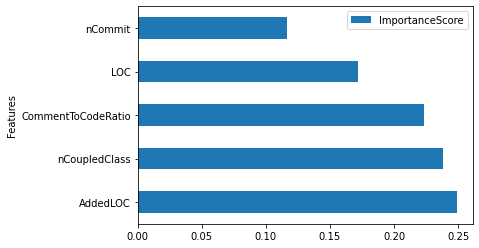

In [2]:
# get VarImp score from the rf_model
feature_importances = pd.DataFrame({'Features': features,
             'ImportanceScore': rf_model.feature_importances_})
feature_importances.sort_values(by = 'ImportanceScore', ascending = False, inplace = True)

# visualize VarImp
feature_importances.plot(kind = 'barh', y = 'ImportanceScore', x = 'Features') # remove the residual